# Avaliação 2

### Questão 1
Utilizando a base Titanic disponível no kaggle (https://www.kaggle.com/c/titanic/data) elabore uma solução utilizando dois algoritmos de aprendizagem de máquina do seu conhecimento para classificar se o passageiro tem ou não chance de sobreviver. Os resultados dessa questão deverão ser descritos detalhadamente no relatório.
* Lembre de fazer todo o pré-processamento, explicando suas decisões;
* Avalie os resultados usando diferentes métricas.
* Teste 3 variações de parâmetros dos métodos;

#### Pré-processamento

É dado início ao pré-processamento, importando as bibliotecas necessárias e instanciando os databases forneceidos através do pandas.

É importante entender que:
* __gs__ equivale à instância do database que contém as saídas (coluna *Survived*) corretas para os testes
* __tr__ equivale à instância do database que contém os treinos
* __ts__ equivale à instância do database que contém os testes

Vale lembrar que o database __gs__ refere-se ao __teste__, e que o __teste__ não pertence ao treino. Portanto será interessante unir os dois databases futuramente.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import cluster, neighbors, svm, metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

gs = pd.read_csv("data/gender_submission.csv",sep=",")
tr = pd.read_csv("data/train.csv",sep=",")
ts = pd.read_csv("data/test.csv",sep=",")

#### Avaliando a quantidade de itens em cada database

Para entender a quantidade de itens com o qual se está trabalhando, é feita uma leitura através do comando __*len()*__.

In [2]:
print("Tamanho do database de treino:", len(tr))
print("Tamanho do database de testes:", len(ts))
print("Tamanho do database que contém as saídas corretas do teste:", len(gs))

Tamanho do database de treino: 891
Tamanho do database de testes: 418
Tamanho do database que contém as saídas corretas do teste: 418


#### Unindo todos os databases

Para passarem pelo pré-processamento, é interessante que todos os dados estejam juntos. Desta forma o __gs__ será unido ao __ts__, que será, por sua vez, unido ao __tr__.

❗️ __Utilizaremos o termo *dfTotal* para se referir ao DataFrame completo, que inclui o teste e o treino.__ ❗️

In [3]:
dfTotal = pd.concat([tr,pd.concat([gs, ts.drop(columns=['PassengerId'])], axis=1)])

#### Analisando quantos itens nulos há no database

É importante conhecer quantos itens nulos existem no database para entender qual deve ser a medida adequada a se tomar mediante a quantidade de itens nulos.

In [4]:
print("-->Nulidade:")
print(dfTotal.isnull().sum())

-->Nulidade:
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


⚠️ __Os itens nulos de cabine representam, no treino, mais de 77% do total de informações. Excluir todas essas informações pode representar uma alta perda ao treinamento do IA, ao passo que completar todo esse conteúdo com informações aleatórias ou fixas também podem trazer algum nível de imprecisão aos testes. Desta forma, optou-se por excluir essa coluna.__ ⚠️

#### Excluindo a coluna de Cabine

Como dito acima, a coluna *Cabin* apresenta muitos valores nulos. Desta forma passa a ser interessante excluir essa coluna.

In [5]:
dfTotal = dfTotal.drop(columns=['Cabin'])

#### Analisando quantos itens nulos há no database

Ainda analisando a quantidade de elementos nulos, será feita a análise novamente agora sem a coluna de cabine, que previamente apresentou várias informações faltantes.

In [6]:
print("-->Nulidade:")
print(dfTotal.isnull().sum())

-->Nulidade:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Embarked         2
dtype: int64


❗️ __Considerando que *Fare* (Tarifa) e *Embarked* apresentam uma quantidade ínfima de valores nulos, considerou-se interessante, na coluna Fare, considerar a mediana no lugar do valor nulo e, no Embarked, o uso da moda dos valores.__ ❗️

#### Substituindo valores de Fare, Age e Embarked

Será considerada a moda dos valores de __Embarked__ para substituir os valores nulos e a mediana de __Fare__ e __Age__ para substituir os valores faltantes.

Note que, por mais que haja uma quantidade mais expressiva de valores nulos para *Age*, isso representa apenas 20%, da quantidade total. Sendo assim é entendeu-se como viável substituir os valores de idade pela mediana de todas as idades.

In [7]:
dfTotal["Fare"].fillna(dfTotal["Fare"].median(), inplace=True)
print(dfTotal.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64


In [8]:
dfTotal["Embarked"].fillna(dfTotal["Embarked"].mode()[0],inplace=True)
print(dfTotal.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64


In [9]:
dfTotal["Age"].fillna(dfTotal["Age"].median(),inplace=True)
print(dfTotal.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


#### Removendo colunas

Algumas colunas não auxiliam, pelo contrário, atrapalham o funcionamento do IA por apresentarem valores únicos para cada entidade. Desta forma, devem ser removidas as colunas:
* Name
* Ticket
* PassengerId


In [10]:
dfTotal = dfTotal.drop(columns=['Name','Ticket','PassengerId'])

#### Linhas duplicadas

Com a remoção das colunas, algumas linhas possuem valores exatamente iguais, não agregando em nada ao IA. Sendo assim, primeiramente será feita a análise de quantas linhas estão duplicadas:

In [11]:
print("Total de duplicações no database:",dfTotal.duplicated().sum())

Total de duplicações no database: 209


#### Remoção de linhas duplicadas

Existem 209 linhas duplicadas. Agora é interessante apagar essas duplicações que não agregam em nada ao IA.

In [12]:
dfTotal = dfTotal.drop_duplicates()
print("Conferindo o total de duplicações após apagar as linhas duplicadas:",dfTotal.duplicated().sum())

Conferindo o total de duplicações após apagar as linhas duplicadas: 0


#### Substituindo valores

Como um dos métodos a ser utilizado na análise será o KNN, então é necessário que todas as colunas sejam numéricas. Sendo assim, as colunas "Sex" e "Embarked" serão categorizadas em números:
* __Sex__
    * *male* passa a ser 0
    * *female* passa a ser 1
* __Embarked__
    * *C* passa a ser 0
    * *Q* passa a ser 1
    * *S* passa a ser 2

In [13]:
dfTotal['Sex'] = dfTotal['Sex'].replace('male',0)
dfTotal['Sex'] = dfTotal['Sex'].replace('female',1)

dfTotal['Embarked'] = dfTotal['Embarked'].replace('C',0)
dfTotal['Embarked'] = dfTotal['Embarked'].replace('Q',1)
dfTotal['Embarked'] = dfTotal['Embarked'].replace('S',2)

#### Analisando integridade dos dados

É importante saber se os dados estão dispostos de forma íntegra. Uma das análises realizadas no presente trabalho será analisar, caso a caso, se a disposição de categorias para cada coluna está feita da maneira correta. 
* Para a coluna __"Survived"__ os valores possíveis são 0 e 1
* Para a coluna __"Sex"__ os valores possíveis são 0 e 1
* Para a coluna __"Pclass"__ os valores possíveis são 1, 2 e 3
* Para a coluna __"Embarked"__ os valores possíveis são 0, 1 e 2

⚠️ __A coluna *Age* representa a idade de cada tripulante. Desta forma não faz sentido categorizar a idade, muito embora ela seja analisada de forma matemática mais adiante. Da mesma forma, a coluna *Fare* representa o preço e também será analisado de forma matemática mais adiante. Parch e SibSp representam, respectivamente número de pais/filhos tripulantes e número de irmãos/cônjuges a bordo, e, desta forma, também não é interessante tratá-los de forma categórica.__ ⚠️


In [14]:
print("Analisando valores de Survived:")
dfTotal.groupby(['Survived']).count()

Analisando valores de Survived:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,,,,,,,
0,644,644,644,644,644,644,644
1,456,456,456,456,456,456,456


In [15]:
print("Analisando valores de Sex:")
dfTotal.groupby(['Sex']).count()

Analisando valores de Sex:


,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
Sex,,,,,,,
0,672,672,672,672,672,672,672
1,428,428,428,428,428,428,428


In [16]:
print("Analisando valores de Pclass:")
dfTotal.groupby(['Pclass']).count()

Analisando valores de Pclass:


,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
Pclass,,,,,,,
1,311,311,311,311,311,311,311
2,238,238,238,238,238,238,238
3,551,551,551,551,551,551,551


In [17]:
print("Analisando valores de Embarked:")
dfTotal.groupby(['Embarked']).count()

Analisando valores de Embarked:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Embarked,,,,,,,
0,247,247,247,247,247,247,247
1,84,84,84,84,84,84,84
2,769,769,769,769,769,769,769


✅ __As 4 colunas listadas estão categorizadas de forma adequada, não havendo nenhuma linha categorizada com uma classe que não exista.__ ✅

#### Análise de Variância, Desvio Padrão e Outliers

As colunas que não foram analisadas e não estão dispostas em classes devem ser analisadas de outra forma. Sendo assim, cabe uma análise para conhecer variância, desvio padrão e outliers para as colunas:
* Age
* Fare
* SibSp
* Parch

##### Age

In [18]:
mean  = np.mean(dfTotal['Age'], axis=0)
sd    = np.std(dfTotal['Age'], axis=0)

print("Média:",mean)
print("Desvio padrão:",sd)

Média: 29.860836363636363
Desvio padrão: 13.860256931586331


In [19]:
limitMax = mean + 2*sd

print("Limite de idade para outliers:",limitMax)

Limite de idade para outliers: 57.58135022680902


Gráfico de Outliers


<AxesSubplot:xlabel='Age'>

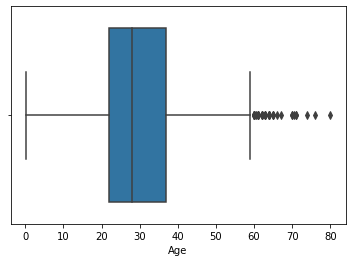

In [20]:
print("Gráfico de Outliers")
sns.boxplot(x=dfTotal['Age'])

In [21]:
print("Idade máxima:",max(dfTotal['Age']))
print("Idade mínima:",min(dfTotal['Age']))

Idade máxima: 80.0
Idade mínima: 0.17


⚠️ __Muito embora o limite de idade calculado (idades maiores que o limite calculado são os outliers) seja pouco mais que 57 anos, observe que a maior idade foi 80. Sendo assim, é notório que estes outliers podem ser considerados na análise do IA, enriquecem a análise e não trazem danos e serão mantidos no database.__ ⚠️

##### Fare

In [22]:
mean  = np.mean(dfTotal['Fare'], axis=0)
sd    = np.std(dfTotal['Fare'], axis=0)

print("Média:",mean)
print("Desvio padrão:",sd)

Média: 36.96133709090912
Desvio padrão: 55.29126122115588


In [23]:
limitMax = mean + 2*sd

print("Limite de tarifa para outliers:",limitMax)

Limite de tarifa para outliers: 147.54385953322088


Gráfico de Outliers


<AxesSubplot:xlabel='Fare'>

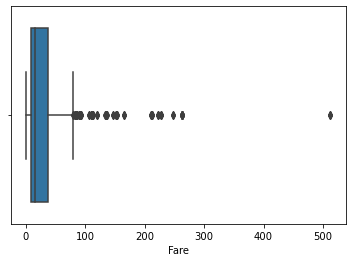

In [24]:
print("Gráfico de Outliers")
sns.boxplot(x=dfTotal['Fare'])

In [25]:
print("Tarifa máxima: £",max(dfTotal['Fare']))
print("Tarifa mínima: £",min(dfTotal['Fare']))

Tarifa máxima: £ 512.3292
Tarifa mínima: £ 0.0


❗️ __As análises matemáticas acima para a coluna de tarifa requerem uma observação um pouco mais subjetiva.__ ❗️

Em primeiro lugar observe a Tarifa mínima paga por um tripulante: £0,00. Isso significa que ele entrou de graça. O que isso pode significar. Há a possibilidade de ser apenas um erro no database, como também há a possibilidade de ser algum tipo de "promoção" dedicada a algum critério, ou simplesmente tripulantes que "pularam a catraca". 
Para validar ou invalidar será analisado quantas pessoas entraram sem pagar na tripulação. Com essa informação, caso mais de uma pessoa participe, será entendido que pode ter sido casos de pessoas que puderam entrar sem pagar e, portanto, devem ser consideradas no IA. Caso contrário o usuário será desconsiderado e removido do database.

Da mesma forma, para a tarifa máxima no gráfico é possível observar uma grande diferença da maior tarifa paga em relação às demais e será feita uma análise de quantas pessoas pagaram mais de £500,00.

In [26]:
print("Quantidade de não pagantes:",len(dfTotal.loc[dfTotal['Fare']==0]))
print("Quantidade de pagantes acima de £500,00:",len(dfTotal.loc[dfTotal['Fare']>=500]))

Quantidade de não pagantes: 10
Quantidade de pagantes acima de £500,00: 4


⚠️ __Observe que tanto para não pagantes quanto para pagantes de um valor acima de £500 não foram casos isolados. Entende-se, então que houve não pagantes na tripulação, bem como houve pessoas com extremas condições para pagar mais de £500,00 pela viagem e, sendo assim, todos os dados referentes a Tarifa serão mantidos.__ ⚠️

##### SibSp

In [27]:
mean  = np.mean(dfTotal['SibSp'], axis=0)
sd    = np.std(dfTotal['SibSp'], axis=0)

print("Média:",mean)
print("Desvio padrão:",sd)

Média: 0.5290909090909091
Desvio padrão: 0.9844560523498476


In [28]:
limitMax = mean + 2*sd

print("Limite de quantidade de irmãos/cônjuges para outliers:",limitMax)

Limite de quantidade de irmãos/cônjuges para outliers: 2.498003013790604


Gráfico de Outliers


<AxesSubplot:xlabel='SibSp'>

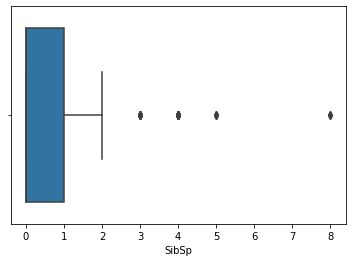

In [29]:
print("Gráfico de Outliers")
sns.boxplot(x=dfTotal['SibSp'])

In [30]:
print("Quantidade de irmãos/cônjuges máxima:",max(dfTotal['SibSp']))
print("Quantidade de irmãos/cônjuges mínima:",min(dfTotal['SibSp']))

Quantidade de irmãos/cônjuges máxima: 8
Quantidade de irmãos/cônjuges mínima: 0


✅ __Os dados são completamente satisfatórios, uma vez que é muito possível que uma pessoa contenha 8 irmãos e o cônjuge ou que não tenha nem irmãos nem cônjuge na viagem, não sendo adequado fazer nenhuma remoção.__ ✅

##### Parch

In [31]:
mean  = np.mean(dfTotal['Parch'], axis=0)
sd    = np.std(dfTotal['Parch'], axis=0)

print("Média:",mean)
print("Desvio padrão:",sd)

Média: 0.44181818181818183
Desvio padrão: 0.918138612844859


In [32]:
limitMax = mean + 2*sd

print("Limite de quantidade de pais/filhos para outliers:",limitMax)

Limite de quantidade de pais/filhos para outliers: 2.2780954075079


Gráfico de Outliers


<AxesSubplot:xlabel='Parch'>

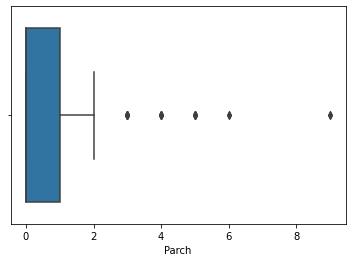

In [33]:
print("Gráfico de Outliers")
sns.boxplot(x=dfTotal['Parch'])

In [34]:
print("Quantidade de pais/filhos máxima:",max(dfTotal['Parch']))
print("Quantidade de pais/filhos mínima:",min(dfTotal['Parch']))

Quantidade de pais/filhos máxima: 9
Quantidade de pais/filhos mínima: 0


✅ __Os dados são completamente satisfatórios, uma vez que é muito possível que uma pessoa contenha 9 filhos e os pais ou que não tenha nem filhos nem pais na viagem, não sendo adequado fazer nenhuma remoção.__ ✅

#### Analisando a correlação

É importante analisar a correlação das colunas, uma vez que colunas podem apresentar informações redundantes ou quase redundantes, causando uma falta de necessidade de uma delas.

In [35]:
corr = dfTotal.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.252715,0.660757,-0.061647,-0.011744,0.089501,0.218534,-0.120102
Pclass,-0.252715,1.000000,-0.105154,-0.381018,0.076442,0.050739,-0.560860,0.214417
Sex,0.660757,-0.105154,1.000000,-0.071113,0.082485,0.196796,0.168297,-0.082788
Age,-0.061647,-0.381018,-0.071113,1.000000,-0.225943,-0.139323,0.171715,-0.064612
SibSp,-0.011744,0.076442,0.082485,-0.225943,1.000000,0.343838,0.134557,0.076037
Parch,0.089501,0.050739,0.196796,-0.139323,0.343838,1.000000,0.194046,0.053754
Fare,0.218534,-0.560860,0.168297,0.171715,0.134557,0.194046,1.000000,-0.250505
Embarked,-0.120102,0.214417,-0.082788,-0.064612,0.076037,0.053754,-0.250505,1.000000


❗️ __Observa-se que há uma correlação entre Sexo e Sobreviventes. Isso pode está associado à quantidade de pessoas e à prioridade de uso dos botes durante o naufragio do navio. Sendo assim a coluna será mantida, uma vez que não há muitas colunas e a correlação possui uma explicação factível, mas ao meu entender, não tão grande a ponto de viabilizar a exclusao da coluna de Sexo.__ ❗️

#### Isolando o treino

É importante isolar o *X* e o *Y* dos treinos, sendo o X os dados da database que serão tirando a saída (*Survived*) e o Y as saídas corretas para cada entidade do treino.

In [36]:
y = dfTotal['Survived'].values
x = dfTotal.drop(columns=['Survived'])

#### Validação cruzada estratificada

Neste ponto será realizada a definição dos parâmetros para realização da validação cruzada estratificada e as métricas de análise, considerando a __Acurácia__, o __F1__ e a __Precisão__.

In [37]:
kf = StratifiedKFold(n_splits=10, random_state=3, shuffle=True)
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'F1':make_scorer(f1_score),
    'Precision':make_scorer(precision_score),
    'Recall':make_scorer(recall_score)
}

#### Método 1 - KNN

Com o algoritmo devidamente pré-processado e pronto para trabalhar nos métodos, primeiro será realizado o tratamento com o KNN. Desta forma, como sendo o K a principal variável do método KNN, entendeu-se como mais interessante mudar os valores de K. Sendo assim, serão considerados os valores:
* K = 1;
* K = 5;
* K = 10.




A métrica utilizada será __Jacccard__.

##### KNN com K = 1

In [38]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric="jaccard", algorithm="auto")
scores = cross_validate(knn, x, y, cv=kf,scoring=scoring)
print("Acurácia Média: %.2f" %(np.mean(scores['test_Accuracy'])))
print("F1 Médio: %.2f" %(np.mean(scores['test_F1'])))
print("Precisão Média: %.2f" %(np.mean(scores['test_Precision'])))
print("Recall Média: %.2f" %(np.mean(scores['test_Recall'])))

Acurácia Média: 0.74
F1 Médio: 0.69
Precisão Média: 0.67
Recall Média: 0.72


##### KNN com K = 5

In [39]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 5, metric="jaccard", algorithm="auto")
scores = cross_validate(knn, x, y, cv=kf,scoring=scoring)
print("Acurácia Média: %.2f" %(np.mean(scores['test_Accuracy'])))
print("F1 Médio: %.2f" %(np.mean(scores['test_F1'])))
print("Precisão Média: %.2f" %(np.mean(scores['test_Precision'])))
print("Recall Média: %.2f" %(np.mean(scores['test_Recall'])))

Acurácia Média: 0.77
F1 Médio: 0.71
Precisão Média: 0.72
Recall Média: 0.72


##### KNN com K = 10

In [40]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 10, metric="jaccard", algorithm="auto")
scores = cross_validate(knn, x, y, cv=kf,scoring=scoring)
print("Acurácia Média: %.2f" %(np.mean(scores['test_Accuracy'])))
print("F1 Médio: %.2f" %(np.mean(scores['test_F1'])))
print("Precisão Média: %.2f" %(np.mean(scores['test_Precision'])))
print("Recall Média: %.2f" %(np.mean(scores['test_Recall'])))

Acurácia Média: 0.84
F1 Médio: 0.79
Precisão Média: 0.82
Recall Média: 0.77


✅ __Observa-se que a acurácia apresenta uma precisão maior com 10 vizinhos (K igual a 10). 83% de acertos é uma quantidade muito boa. O menos preciso, entretanto, apresenta 71% de acerto, com 1 vizinho (K igual a 1).__ ✅

#### Método 2 - Naive Bayes

Com o método Naive Bayes será realizado os testes e analizada as acurácias alterando o parâmetro __var_smoothing__. Os valores testados são:
* 1e-09
* 1e-03
* 1e-05

In [41]:
clf = GaussianNB(var_smoothing = 1e-09)
scores = cross_validate(clf, x, y, cv=kf, scoring=scoring)
print("Acurácia Média: %.4f" %(np.mean(scores['test_Accuracy'])))
print("F1 Médio: %.4f" %(np.mean(scores['test_F1'])))
print("Precisão Média: %.4f" %(np.mean(scores['test_Precision'])))
print("Recall Média: %.4f" %(np.mean(scores['test_Recall'])))

Acurácia Média: 0.8182
F1 Médio: 0.7771
Precisão Média: 0.7915
Recall Média: 0.7678


In [42]:
clf = GaussianNB(var_smoothing = 1e-03)
scores = cross_validate(clf, x, y, cv=kf, scoring=scoring)
print("Acurácia Média: %.4f" %(np.mean(scores['test_Accuracy'])))
print("F1 Médio: %.4f" %(np.mean(scores['test_F1'])))
print("Precisão Média: %.4f" %(np.mean(scores['test_Precision'])))
print("Recall Média: %.4f" %(np.mean(scores['test_Recall'])))

Acurácia Média: 0.6409
F1 Médio: 0.3230
Precisão Média: 0.7316
Recall Média: 0.2126


In [43]:
clf = GaussianNB(var_smoothing = 1e-05)
scores = cross_validate(clf, x, y, cv=kf, scoring=scoring)
print("Acurácia Média: %.4f" %(np.mean(scores['test_Accuracy'])))
print("F1 Médio: %.4f" %(np.mean(scores['test_F1'])))
print("Precisão Média: %.4f" %(np.mean(scores['test_Precision'])))
print("Recall Média: %.4f" %(np.mean(scores['test_Recall'])))

Acurácia Média: 0.8245
F1 Médio: 0.7853
Precisão Média: 0.7990
Recall Média: 0.7766


✅ __Observa-se que a acurácia apresenta uma precisão maior com var_smoothing igual a 1e-05. 82% de acertos é uma boa quantidade, muito embora ainda seja menor que a quantidade observada com o KNN. O menos preciso, entretanto, apresenta 64% de acertos, com var_smooting igual a 1e-03, e 64% de acertos, muito abaixo, inclusive, do pior caso de KNN.__ ✅

### Conclusão

Observa-se que para a forma como os dados foram tratados o *KNN* se mostra como a melhor alternativa. Entretanto isso não inviabiliza o uso do Naive Bayes, uma vez que seu uso passa a ser mais adequado em outro tipo de cenário.